# Deep Learning and Reinforcement Learning

This is the final assessment project for course 5 of [IBM Machine Learning Specialization](https://www.coursera.org/specializations/ibm-machine-learning).

# About the data

We'll be working with [Sentiment Labelled Sentences](https://archive.ics.uci.edu/dataset/331/sentiment+labelled+sentences)
dataset provided by [UCI Machine Learning Repository](https://archive.ics.uci.edu). This dataset was originally created for
the following paper, published in Knowledge Discovery and Data Mining (KDD) :

[From Group to Individual Labels Using Deep Features (2015)](https://www.semanticscholar.org/paper/From-Group-to-Individual-Labels-Using-Deep-Features-Kotzias-Denil/6531ab52738e5457a5e9b4b2e014cf5ecb82820a), by :
- Dimitrios Kotzias
- Misha Denil
- Nando de Freitas
- Padhraic Smyth

This dataset contains 3000 reviews labelled with positive (1) or negative (0) sentiment. These reviews are collected from three different sources :
- Movie reviews from [IMDB](https://www.imdb.com)
- Cell phone reviews from [Amazon](https://www.amazon.com)
- Food reviews from [Yelp](https://www.yelp.com)

There are 500 positive and 500 negative reviews from each site (collected and labelled in separate text files). These reviews are randomly collected from a larger dataset to contain strictly positive or negative items (i.e. no neutral sentiments). Each text file contains 1000 reviews and each line contains a single review (English text) and its corresponding label (0 or 1), separated by a single tab character.

# Objectives

We want to conduct Sentiment Analysis on this dataset. The main objective is to predict a person's sentiment on a movie, cell phone or food by training different models on existing reviews in our dataset.

We're going to use a simple approach for final model evaluation and selection. Using the performance of an initial model as baseline, we'll train several artificial neural networks (ANNs) and try to come up with an optimal model (i.e. ANN architecture and parameters) that outperforms the baseline model.

Please run the following cells to setup notebook environment.

## Environment setup

In [1]:
import os, re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import EnglishStemmer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report

from keras.models import Sequential
from keras.layers import Dense, LeakyReLU
from keras.optimizers import Adam, SGD, RMSprop

%matplotlib inline

In [2]:
# Suppress all warnings (mostly from Keras recommendations)
import warnings
def warn(*args, **kwargs):
    pass

warnings.warn = warn

# Choose a random state to produce repeatable results
rs = 147

Let's define some utility functions that are used in the rest of this notebook.

In [3]:
# Applies base preprocessing to a single document
def preprocess(document):
    stop_words = stopwords.words('english')
    emot_re = r'(?::|;|=)(?:-)?(?:\)|\(|D|P)'

    # Find emoticons in document
    emoticons = re.findall(emot_re, document)

    # Remove punctuation, special characters, digits and stop words
    document = re.sub(r'[\W]+', ' ', document.lower())
    document = re.sub(r'\d+', ' ', document)
    words  = [word for word in document.split() if word not in stop_words]

    # Reconstruct document from words and emoticons (if any)
    document = ' '.join(words + emoticons)

    return document

In [4]:
# Evaluates model metrics and return results as a Pandas Series
def eval_metrics(y, yhat, model_name):
    accuracy = accuracy_score(y, yhat)
    precision, recall, f1score, _ = precision_recall_fscore_support(y, yhat, average='weighted')
    return pd.Series({'Model': model_name,
                      'Accuracy': round(accuracy, 3),
                      'Precision': round(precision, 3),
                      'Recall': round(recall, 3),
                      'F1 score': round(f1score, 3)})

# Aggregates given metrics as a Pandas DataFrame
def agg_metrics(all_metrics):
    return pd.DataFrame(pd.concat(all_metrics, axis=1)).T.set_index('Model')

In [5]:
# Given a Keras history object, plots train vs. validation accuracy and loss
def plot_nn_history(hist):
    fix, ax = plt.subplots(1, 2, figsize=(10, 6))
    ax[0].plot(range(1, epochs+1), hist.history['accuracy'], 'b-', label='Train accuracy')
    ax[0].plot(range(1, epochs+1), hist.history['val_accuracy'], 'r-', label='Validation accuracy')
    ax[0].set(xlabel='Epoch', ylabel='Accuracy')
    ax[0].legend()
    
    ax[1].plot(range(1, epochs+1), hist.history['loss'], 'b-', label='Train loss')
    ax[1].plot(range(1, epochs+1), hist.history['val_loss'], 'r-', label='Validation loss')
    ax[1].set(xlabel='Epoch', ylabel='Loss')
    ax[1].legend()
    
    plt.show()

In [6]:
# Evaluates a model on train and test sets and returns result as a Pandas DataFrame
def get_nn_perf_summary(model, X_trn, X_tst, y_trn, y_tst, model_name):
    metric_list = []
    
    y_pred_prob = model.predict(X_trn)
    y_pred_train = (y_pred_prob > 0.5).astype(int)
    metric_list.append(eval_metrics(y_trn, y_pred_train, f'{model_name} - Train'))
    
    y_pred_prob = model.predict(X_tst)
    y_pred_test = (y_pred_prob > 0.5).astype(int)
    metric_list.append(eval_metrics(y_tst, y_pred_test, f'{model_name} - Test'))
    
    return agg_metrics(metric_list)

# Exploratory Data Analysis (EDA)

## Initial data exploration

## Class balance analysis

## Correlation analysis

## Normality analysis

## Outlier analysis

# Data processing

Original dataset contains three text files, each file containing 1000 reviews. The following steps were performed to transform raw data to a form that is suitable and ready for modeling :
- Collecting reviews from all three text files and making an initial DataFrame.
- Preprocessing all reviews by converting to lowercase and removing numbers, punctuations and special characters.
- Carefully detecting emoticons and appending them to the end of each document.
- Removing all stop words using NLTK.
- Building feature vectors using Tf-Idf encoding.

Please run the following cells to see how the above processing operations were done in code.

## Data collection

In [7]:
# Collect reviews and labels from all text files
file_names = ['amazon_cells_labelled.txt', 'imdb_labelled.txt', 'yelp_labelled.txt']
reviews = []
labels = []

for name in file_names:
    path = os.path.join('data', name)
    with open(path, 'r', encoding='utf-8') as file:
        lines = file.readlines()
        reviews.extend([line.split('\t')[0].strip() for line in lines])
        labels.extend([int(line.split('\t')[1]) for line in lines])

In [8]:
# Make a DataFrame from reviews
reviews_df = pd.DataFrame([reviews, labels]).T
reviews_df.columns = ['review', 'sentiment']

# Make sure data frame is successfully built
reviews_df.head()

,review,sentiment
0,So there is no way for me to plug it in here i...,0
1,"Good case, Excellent value.",1
2,Great for the jawbone.,1
3,Tied to charger for conversations lasting more...,0
4,The mic is great.,1


In [9]:
# Check out the count of reviews (must be 3000)
reviews_df.shape

(3000, 2)

In [10]:
# Randomize reviews and save to a CSV file
np.random.seed(rs)

reviews_df = reviews_df.reindex(np.random.permutation(reviews_df.index))
reviews_df.to_csv('data/labelled_reviews.csv', index=False, encoding='utf-8')

# Preview a random sample of saved data frame
reviews_df = pd.read_csv('data/labelled_reviews.csv')
reviews_df.head()

,review,sentiment
0,"It was that year, however, that reminded us th...",1
1,"In other words, the content level of this film...",1
2,The RI style calamari was a joke.,0
3,"The film has great actors, a master director, ...",1
4,The story starts too fast with absolutely no s...,0


## Data preparation

In [11]:
# Build feature vectors using TfidfVectorizer in Scikit-Learn
tfidf = TfidfVectorizer()
reviews_df.review = reviews_df.review.apply(preprocess)
review_bow = tfidf.fit_transform(reviews_df.review).toarray()

idx_to_word = {v: k for k, v in tfidf.vocabulary_.items()}
vocab = dict(sorted(idx_to_word.items(), key=lambda item: item[1]))
columns = list(vocab.values()) + ['sentiment']

In [12]:
# Make a DataFrame containing all feature vectors
bow_df = pd.concat([pd.DataFrame(review_bow), reviews_df.sentiment], axis=1)
bow_df.columns = pd.Index(columns)

bow_df.head()

,aailiyah,abandoned,abhor,ability,able,abound,abroad,absolute,absolutel,absolutely,...,yucky,yukon,yum,yummy,yun,zero,zillion,zombie,zombiez,sentiment
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.324354,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [13]:
# Save resulting data frame to a CSV file for later revisiting
bow_df.to_csv('data/review_bows.csv', index=False, encoding='utf-8')

In [14]:
# Let's do a sanity check with a short positive review
test_item = reviews_df.iloc[1443, :]
test_bow = bow_df.iloc[1443, :]

print(test_item)
print()
print(test_bow[test_bow != 0.0])

review       searched internet found one best value
sentiment                                         1
Name: 1443, dtype: object

best         0.303639
found        0.379550
internet     0.451090
one          0.265646
searched     0.541363
value        0.443420
sentiment    1.000000
Name: 1443, dtype: float64


# Model training

The modeling process can be summarized as below :
- Training a default Logistic Regression model and using its performance as baseline
- Training several sequential neural networks with different architectures and hyperparameters
- Aggregating train/test metrics from each model
- Deciding if any trained network can beat our baseline performance

Please run the following cells to follow the modeling process.

In [15]:
# Prepare features and labels
X = bow_df.iloc[:, :-1].values
y = bow_df.iloc[:, -1:].values.ravel()

# Perform a train/test split using 80% for training set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rs)
print(f'Train set shapes : {X_train.shape}\t{y_train.shape}')
print(f'Test  set shapes : {X_test.shape}\t{y_test.shape}')

Train set shapes : (2400, 4933)	(2400,)
Test  set shapes : (600, 4933)	(600,)


## Logistic Regression (baseline)

In [16]:
lr = LogisticRegression(random_state=rs)
lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)
eval_metrics(y_test, y_pred, 'Logistic Regression')

Model        Logistic Regression
Accuracy                   0.825
Precision                  0.826
Recall                     0.825
F1 score                   0.825
dtype: object

## Sequential neural networks

We're going to train several sequential neural networks using Keras' Sequential model. For each model, the following steps will be performed :
- Create, compile and train the model, using predefined hyperparameters
- Evaluate the model using both train and test sets and view aggregated results
- Plot train/test accuracy and loss to see if the model is overfitting

### Model 1 : Single layer, 8 nodes, SGD with lr = 0.01, 100 epochs

In [17]:
model_name = '(8,) SGD'
epochs = 100
l_rate = 0.01

optimizer = SGD(learning_rate=l_rate)

ann_1 = Sequential()
ann_1.add(Dense(8, input_shape=(X_train.shape[1],), activation='relu'))
ann_1.add(Dense(1, activation='sigmoid'))

ann_1.compile(optimizer, 'binary_crossentropy', metrics=['accuracy'])
hist_1 = ann_1.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs)

Epoch 1/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.4970 - loss: 0.6934 - val_accuracy: 0.5350 - val_loss: 0.6925
Epoch 2/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5197 - loss: 0.6924 - val_accuracy: 0.5317 - val_loss: 0.6925
Epoch 3/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5479 - loss: 0.6926 - val_accuracy: 0.5433 - val_loss: 0.6924
Epoch 4/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5577 - loss: 0.6923 - val_accuracy: 0.5433 - val_loss: 0.6923
Epoch 5/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5190 - loss: 0.6924 - val_accuracy: 0.5483 - val_loss: 0.6922
Epoch 6/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5624 - loss: 0.6919 - val_accuracy: 0.5550 - val_loss: 0.6920
Epoch 7/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5541 - loss: 0.6920 - val_accuracy: 0.5600 - val_loss: 0.6919
Epoch 8/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5563 - loss: 0.6916 - val_accuracy: 0.5650 - v

In [18]:
get_nn_perf_summary(ann_1, X_train, X_test, y_train, y_test, model_name)

75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


,Accuracy,Precision,Recall,F1 score
Model,,,,
"(8,) SGD - Train",0.846,0.852,0.846,0.846
"(8,) SGD - Test",0.762,0.775,0.762,0.758


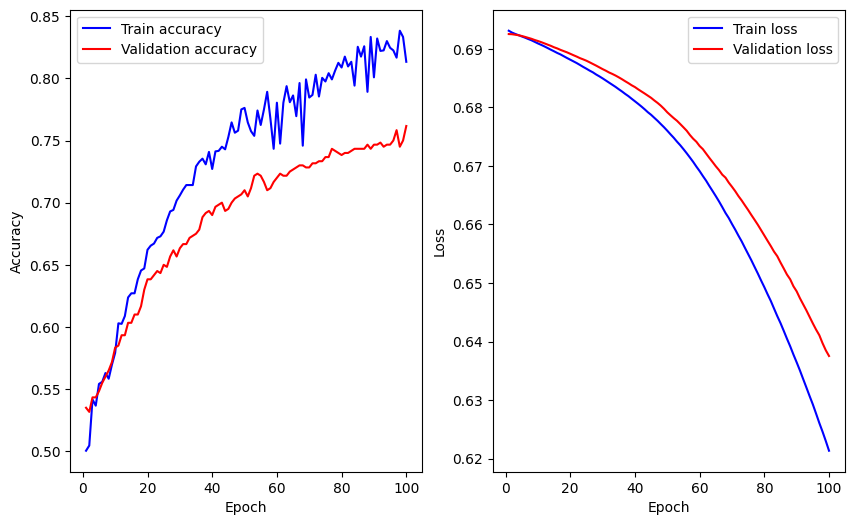

In [19]:
plot_nn_history(hist_1)

This model starts overfitting around epoch 20 (train accuracy ~= 67%, validation accuracy ~= 64%)

### Model 2 : Single layer, 16 nodes, SGD with lr = 0.01, 100 epochs

In [20]:
model_name = '(16,) SGD'
epochs = 100
l_rate = 0.01

optimizer = SGD(learning_rate=l_rate)

ann_2 = Sequential()
ann_2.add(Dense(16, input_shape=(X_train.shape[1],), activation='relu'))
ann_2.add(Dense(1, activation='sigmoid'))

ann_2.compile(optimizer, 'binary_crossentropy', metrics=['accuracy'])
hist_2 = ann_2.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs)

Epoch 1/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5272 - loss: 0.6928 - val_accuracy: 0.5233 - val_loss: 0.6925
Epoch 2/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5243 - loss: 0.6926 - val_accuracy: 0.5333 - val_loss: 0.6921
Epoch 3/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5631 - loss: 0.6919 - val_accuracy: 0.5267 - val_loss: 0.6917
Epoch 4/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5677 - loss: 0.6912 - val_accuracy: 0.5333 - val_loss: 0.6912
Epoch 5/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5790 - loss: 0.6908 - val_accuracy: 0.5417 - val_loss: 0.6907
Epoch 6/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5887 - loss: 0.6897 - val_accuracy: 0.5700 - val_loss: 0.6901
Epoch 7/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5822 - loss: 0.6893 - val_accuracy: 0.5817 - val_loss: 0.6895
Epoch 8/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6293 - loss: 0.6884 - val_accuracy: 0.5750 - v

In [21]:
get_nn_perf_summary(ann_2, X_train, X_test, y_train, y_test, model_name)

75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


,Accuracy,Precision,Recall,F1 score
Model,,,,
"(16,) SGD - Train",0.847,0.858,0.847,0.846
"(16,) SGD - Test",0.777,0.802,0.777,0.771


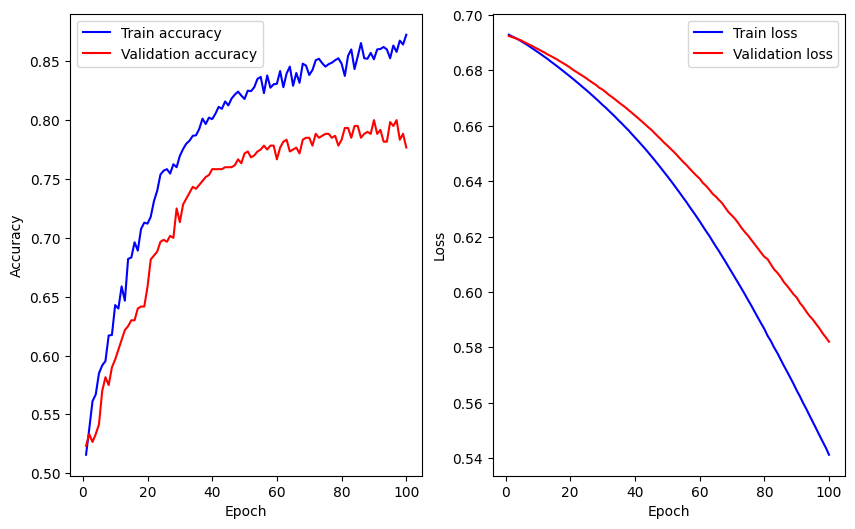

In [22]:
plot_nn_history(hist_2)

This model starts overfitting around epoch 40 (train accuracy ~= 80%, validation accuracy ~= 76%)

### Model 3 : Single layer, 8 nodes, Adam with lr = 0.001, 20 epochs

In [23]:
model_name = '(8,) Adam'
epochs = 20
l_rate = 0.001

optimizer = Adam(learning_rate=l_rate)

ann_3 = Sequential()
ann_3.add(Dense(8, input_shape=(X_train.shape[1],), activation='relu'))
ann_3.add(Dense(1, activation='sigmoid'))

ann_3.compile(optimizer, 'binary_crossentropy', metrics=['accuracy'])
hist_3 = ann_3.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs)

Epoch 1/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.5765 - loss: 0.6906 - val_accuracy: 0.7433 - val_loss: 0.6784
Epoch 2/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8531 - loss: 0.6623 - val_accuracy: 0.7850 - val_loss: 0.6507
Epoch 3/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9179 - loss: 0.6109 - val_accuracy: 0.7983 - val_loss: 0.6164
Epoch 4/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9346 - loss: 0.5482 - val_accuracy: 0.8183 - val_loss: 0.5792
Epoch 5/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9489 - loss: 0.4820 - val_accuracy: 0.8250 - val_loss: 0.5437
Epoch 6/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9548 - loss: 0.4189 - val_accuracy: 0.8167 - val_loss: 0.5134
Epoch 7/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9475 - loss: 0.3680 - val_accuracy: 0.8483 - val_loss: 0.4869
Epoch 8/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9545 - loss: 0.3214 - val_accuracy: 0.8267 - val_loss:

In [24]:
get_nn_perf_summary(ann_3, X_train, X_test, y_train, y_test, model_name)

75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


,Accuracy,Precision,Recall,F1 score
Model,,,,
"(8,) Adam - Train",0.984,0.984,0.984,0.984
"(8,) Adam - Test",0.832,0.832,0.832,0.832


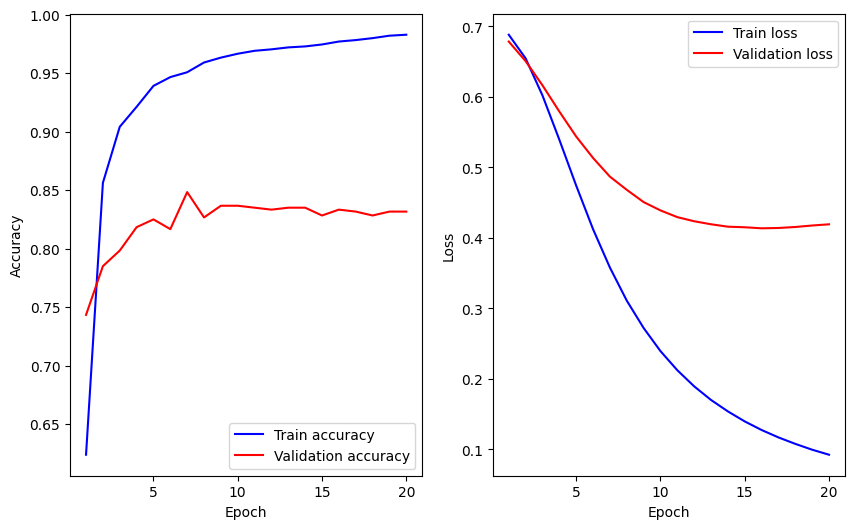

In [25]:
plot_nn_history(hist_3)

This model learns pretty fast and starts overfitting around epoch 5 (train accuracy ~= 95%, validation accuracy ~= 83%)

### Model 4 : Single layer, 64 nodes, Adam with lr = 0.0001, 20 epochs

In [26]:
model_name = '(64,) Adam'
epochs = 20
l_rate = 0.0001

optimizer = Adam(learning_rate=l_rate)

ann_4 = Sequential()
ann_4.add(Dense(64, input_shape=(X_train.shape[1],), activation='relu'))
ann_4.add(Dense(1, activation='sigmoid'))

ann_4.compile(optimizer, 'binary_crossentropy', metrics=['accuracy'])
hist_4 = ann_4.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs)

Epoch 1/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.5513 - loss: 0.6923 - val_accuracy: 0.5933 - val_loss: 0.6912
Epoch 2/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6790 - loss: 0.6882 - val_accuracy: 0.6500 - val_loss: 0.6886
Epoch 3/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8000 - loss: 0.6831 - val_accuracy: 0.6767 - val_loss: 0.6852
Epoch 4/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8540 - loss: 0.6764 - val_accuracy: 0.7367 - val_loss: 0.6806
Epoch 5/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8990 - loss: 0.6672 - val_accuracy: 0.7633 - val_loss: 0.6745
Epoch 6/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9199 - loss: 0.6564 - val_accuracy: 0.7833 - val_loss: 0.6669
Epoch 7/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9283 - loss: 0.6431 - val_accuracy: 0.7950 - val_loss: 0.6580
Epoch 8/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9304 - loss: 0.6283 - val_accuracy: 0.8050 - val_lo

In [27]:
get_nn_perf_summary(ann_4, X_train, X_test, y_train, y_test, model_name)

75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


,Accuracy,Precision,Recall,F1 score
Model,,,,
"(64,) Adam - Train",0.954,0.954,0.954,0.954
"(64,) Adam - Test",0.835,0.835,0.835,0.835


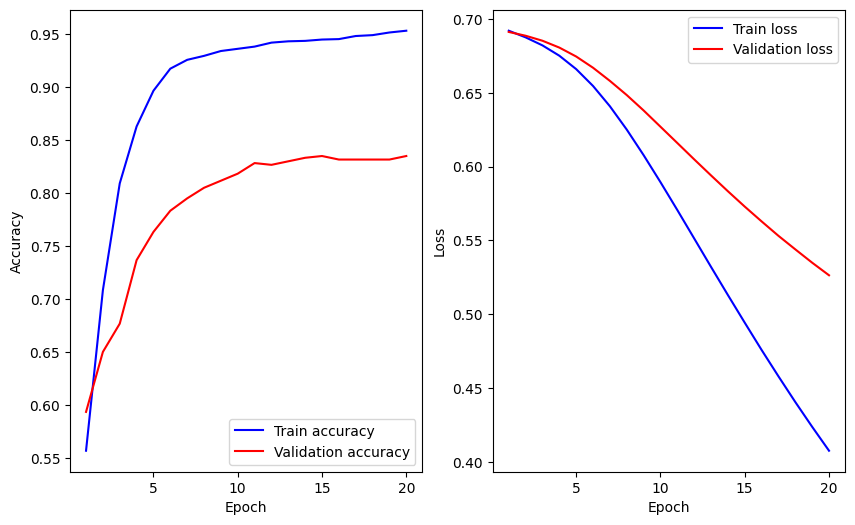

In [28]:
plot_nn_history(hist_4)

Same as model 3, this model starts overfitting around epoch 5 (train accuracy ~= 90%, validation accuracy ~= 76%)

### Model 5 : Two layers (64, 16), SGD with lr = 0.001, 300 epochs

In [29]:
model_name = '(64,16) SGD'
epochs = 300
l_rate = 0.001

optimizer = SGD(learning_rate=l_rate)

ann_5 = Sequential()
ann_5.add(Dense(64, input_shape=(X_train.shape[1],), activation='relu'))
ann_5.add(Dense(16, activation='relu'))
ann_5.add(Dense(1, activation='sigmoid'))

ann_5.compile(optimizer, 'binary_crossentropy', metrics=['accuracy'])
hist_5 = ann_5.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs)

Epoch 1/300
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5201 - loss: 0.6927 - val_accuracy: 0.4883 - val_loss: 0.6934
Epoch 2/300
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5111 - loss: 0.6929 - val_accuracy: 0.4867 - val_loss: 0.6934
Epoch 3/300
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5071 - loss: 0.6928 - val_accuracy: 0.4867 - val_loss: 0.6933
Epoch 4/300
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5073 - loss: 0.6929 - val_accuracy: 0.4883 - val_loss: 0.6933
Epoch 5/300
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5165 - loss: 0.6928 - val_accuracy: 0.4867 - val_loss: 0.6933
Epoch 6/300
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5309 - loss: 0.6927 - val_accuracy: 0.4850 - val_loss: 0.6933
Epoch 7/300
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5456 - loss: 0.6923 - val_accuracy: 0.4867 - val_loss: 0.6932
Epoch 8/300
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5492 - loss: 0.6923 - val_accuracy: 0.4850 - 

In [30]:
get_nn_perf_summary(ann_5, X_train, X_test, y_train, y_test, model_name)

75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


,Accuracy,Precision,Recall,F1 score
Model,,,,
"(64,16) SGD - Train",0.783,0.784,0.783,0.783
"(64,16) SGD - Test",0.733,0.733,0.733,0.733


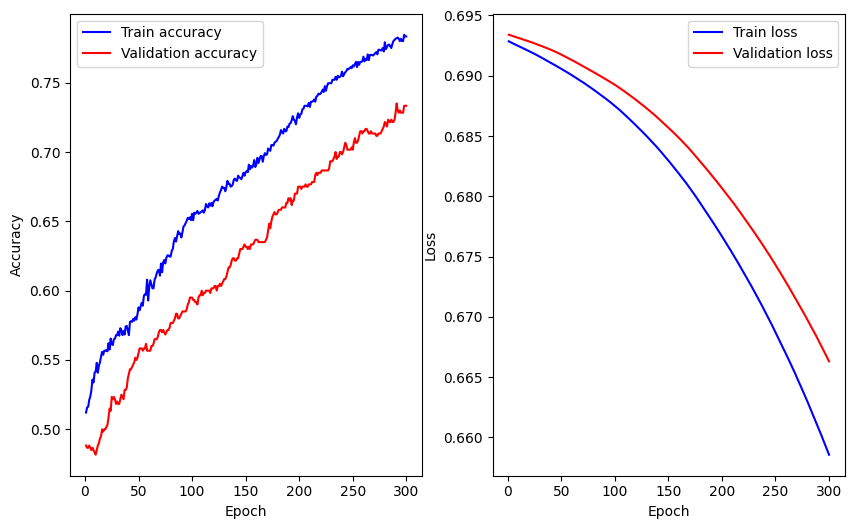

In [31]:
plot_nn_history(hist_5)

This model trains rather slowly and reaches mediocre accuracy (train accuracy ~= 78%, validation accuracy ~= 73%)

Although it seems like this model may achieve higher accuracy with more epochs, it already seems to be overfitting. Let's try again with a higher learning rate.

### Model 6 : Two layers (64, 16), SGD with lr = 0.01, 150 epochs

In [32]:
model_name = '(64,16) SGD'
epochs = 150
l_rate = 0.01

optimizer = SGD(learning_rate=l_rate)

ann_6 = Sequential()
ann_6.add(Dense(64, input_shape=(X_train.shape[1],), activation='relu'))
ann_6.add(Dense(16, activation='relu'))
ann_6.add(Dense(1, activation='sigmoid'))

ann_6.compile(optimizer, 'binary_crossentropy', metrics=['accuracy'])
hist_6 = ann_6.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs)

Epoch 1/150
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5107 - loss: 0.6928 - val_accuracy: 0.5383 - val_loss: 0.6922
Epoch 2/150
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5243 - loss: 0.6924 - val_accuracy: 0.5483 - val_loss: 0.6920
Epoch 3/150
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5420 - loss: 0.6925 - val_accuracy: 0.5583 - val_loss: 0.6917
Epoch 4/150
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5575 - loss: 0.6919 - val_accuracy: 0.5617 - val_loss: 0.6915
Epoch 5/150
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5629 - loss: 0.6915 - val_accuracy: 0.5683 - val_loss: 0.6912
Epoch 6/150
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5782 - loss: 0.6915 - val_accuracy: 0.5683 - val_loss: 0.6908
Epoch 7/150
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5915 - loss: 0.6911 - val_accuracy: 0.5950 - val_loss: 0.6904
Epoch 8/150
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5967 - loss: 0.6904 - val_accuracy: 0.6167 - 

In [33]:
get_nn_perf_summary(ann_6, X_train, X_test, y_train, y_test, model_name)

75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


,Accuracy,Precision,Recall,F1 score
Model,,,,
"(64,16) SGD - Train",0.988,0.988,0.988,0.988
"(64,16) SGD - Test",0.835,0.836,0.835,0.835


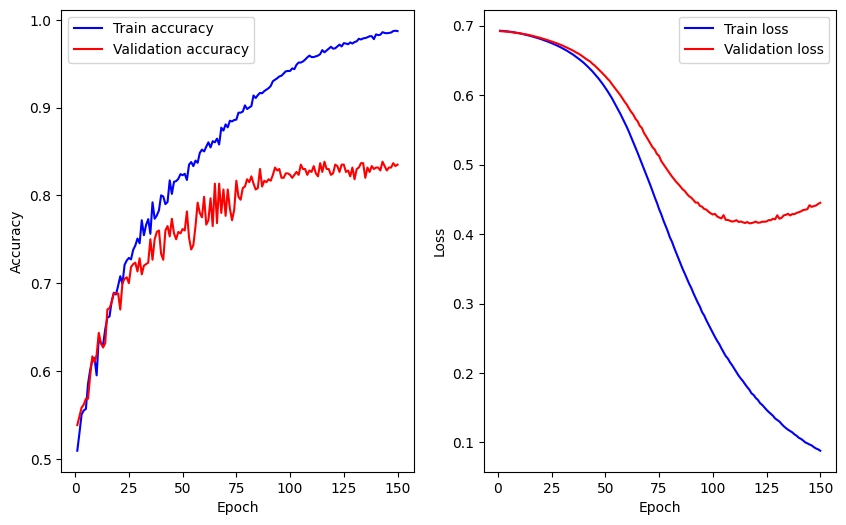

In [34]:
plot_nn_history(hist_6)

This model starts overfitting around epoch 40 (train accuracy ~= 80%, validation accuracy ~= 73%)

### Model 7 : Four layers (128, 64, 64, 8), SGD with lr = 0.005, 100 epochs

In [35]:
model_name = '(128,64,64,8) SGD'
epochs = 100
l_rate = 0.005

optimizer = SGD(learning_rate=l_rate)

ann_7 = Sequential()
ann_7.add(Dense(128, input_shape=(X_train.shape[1],), activation='relu'))
ann_7.add(Dense(64, activation='relu'))
ann_7.add(Dense(64, activation='relu'))
ann_7.add(Dense(8, activation='relu'))
ann_7.add(Dense(1, activation='sigmoid'))

ann_7.compile(optimizer, 'binary_crossentropy', metrics=['accuracy'])
hist_7 = ann_7.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs)

Epoch 1/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.4878 - loss: 0.6932 - val_accuracy: 0.5167 - val_loss: 0.6931
Epoch 2/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5140 - loss: 0.6930 - val_accuracy: 0.5183 - val_loss: 0.6931
Epoch 3/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5304 - loss: 0.6929 - val_accuracy: 0.5150 - val_loss: 0.6930
Epoch 4/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5372 - loss: 0.6927 - val_accuracy: 0.5283 - val_loss: 0.6930
Epoch 5/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5603 - loss: 0.6925 - val_accuracy: 0.5317 - val_loss: 0.6929
Epoch 6/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5465 - loss: 0.6926 - val_accuracy: 0.5483 - val_loss: 0.6928
Epoch 7/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5513 - loss: 0.6926 - val_accuracy: 0.5500 - val_loss: 0.6926
Epoch 8/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5875 - loss: 0.6922 - val_accuracy: 0.5517 

In [36]:
get_nn_perf_summary(ann_7, X_train, X_test, y_train, y_test, model_name)

75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


,Accuracy,Precision,Recall,F1 score
Model,,,,
"(128,64,64,8) SGD - Train",0.863,0.873,0.863,0.863
"(128,64,64,8) SGD - Test",0.76,0.777,0.76,0.755


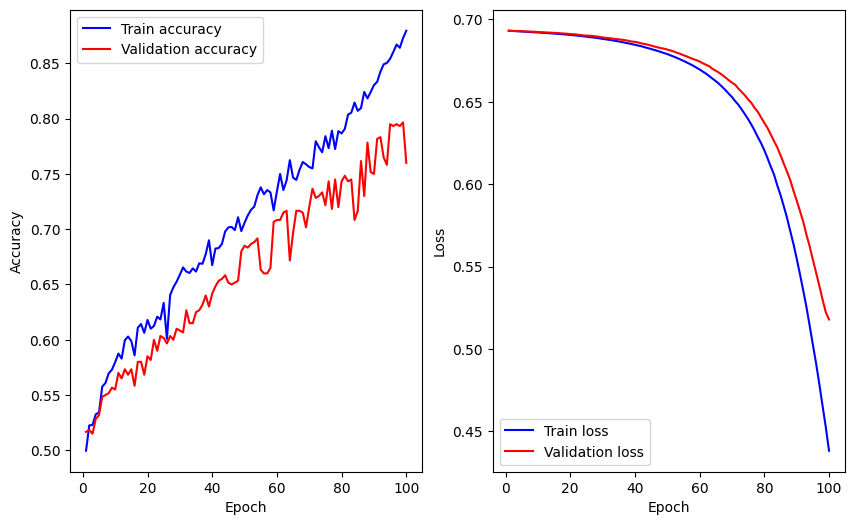

In [37]:
plot_nn_history(hist_7)

This model starts overfitting around epoch 80 (train accuracy ~= 80%, validation accuracy ~= 72%)

Let's revisit our two-layer network with a moderate learning rate, this time using leaky relu activation.

### Model 8 : Two layers (64, 16), SGD with lr = 0.005, 200 epochs, leaky relu activation(0.15)

In [38]:
model_name = '(64,16) SGD'
epochs = 200
l_rate = 0.005

optimizer = SGD(learning_rate=l_rate)
lrelu = LeakyReLU(negative_slope=0.15)

ann_8 = Sequential()
ann_8.add(Dense(64, input_shape=(X_train.shape[1],), activation=lrelu))
ann_8.add(Dense(16, activation=lrelu))
ann_8.add(Dense(1, activation='sigmoid'))

ann_8.compile(optimizer, 'binary_crossentropy', metrics=['accuracy'])
hist_8 = ann_8.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs)

Epoch 1/200
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.4874 - loss: 0.6931 - val_accuracy: 0.5117 - val_loss: 0.6930
Epoch 2/200
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5301 - loss: 0.6929 - val_accuracy: 0.5100 - val_loss: 0.6930
Epoch 3/200
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5145 - loss: 0.6929 - val_accuracy: 0.5133 - val_loss: 0.6929
Epoch 4/200
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5413 - loss: 0.6927 - val_accuracy: 0.5183 - val_loss: 0.6929
Epoch 5/200
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5347 - loss: 0.6928 - val_accuracy: 0.5100 - val_loss: 0.6928
Epoch 6/200
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5363 - loss: 0.6927 - val_accuracy: 0.5033 - val_loss: 0.6928
Epoch 7/200
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5284 - loss: 0.6927 - val_accuracy: 0.5117 - val_loss: 0.6927
Epoch 8/200
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5254 - loss: 0.6927 - val_accuracy: 0.5050 - 

In [39]:
get_nn_perf_summary(ann_8, X_train, X_test, y_train, y_test, model_name)

75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


,Accuracy,Precision,Recall,F1 score
Model,,,,
"(64,16) SGD - Train",0.915,0.916,0.915,0.915
"(64,16) SGD - Test",0.82,0.821,0.82,0.82


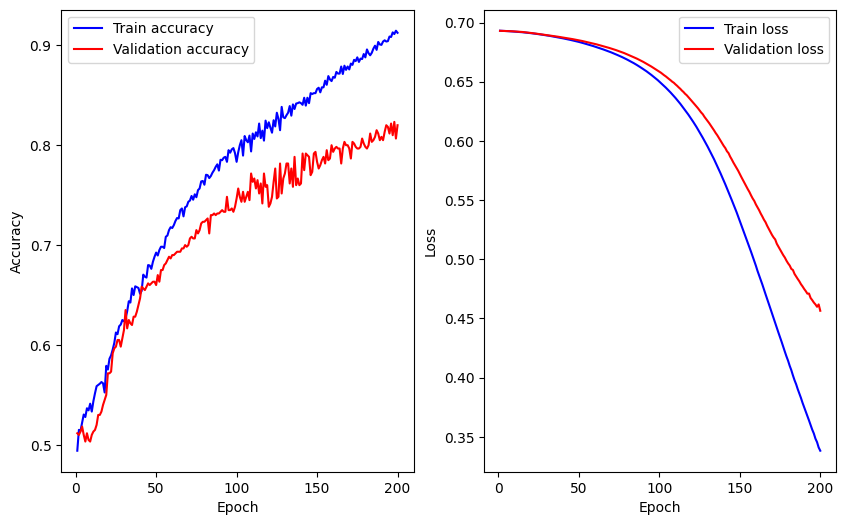

In [40]:
plot_nn_history(hist_8)

This model starts overfitting around epoch 90 (train accuracy ~= 79%, validation accuracy ~= 73%)

It seems like Leaky ReLU didn't work for this dataset. Let's try again with normal relu.

### Model 9 : Two layers (64, 16), SGD with lr = 0.005, 150 epochs, relu activation 

In [41]:
model_name = '(64,16) SGD'
epochs = 150
l_rate = 0.005

optimizer = SGD(learning_rate=l_rate)

ann_9 = Sequential()
ann_9.add(Dense(64, input_shape=(X_train.shape[1],), activation='relu'))
ann_9.add(Dense(16, activation='relu'))
ann_9.add(Dense(1, activation='sigmoid'))

ann_9.compile(optimizer, 'binary_crossentropy', metrics=['accuracy'])
hist_9 = ann_9.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs)

Epoch 1/150
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.4935 - loss: 0.6932 - val_accuracy: 0.4667 - val_loss: 0.6938
Epoch 2/150
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5155 - loss: 0.6931 - val_accuracy: 0.4783 - val_loss: 0.6937
Epoch 3/150
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5171 - loss: 0.6931 - val_accuracy: 0.4800 - val_loss: 0.6936
Epoch 4/150
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5148 - loss: 0.6927 - val_accuracy: 0.4900 - val_loss: 0.6935
Epoch 5/150
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5279 - loss: 0.6926 - val_accuracy: 0.4833 - val_loss: 0.6935
Epoch 6/150
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5326 - loss: 0.6926 - val_accuracy: 0.4883 - val_loss: 0.6934
Epoch 7/150
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5020 - loss: 0.6927 - val_accuracy: 0.4950 - val_loss: 0.6934
Epoch 8/150
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5144 - loss: 0.6927 - val_accuracy: 0.4983 - v

In [42]:
get_nn_perf_summary(ann_9, X_train, X_test, y_train, y_test, model_name)

75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


,Accuracy,Precision,Recall,F1 score
Model,,,,
"(64,16) SGD - Train",0.868,0.87,0.868,0.868
"(64,16) SGD - Test",0.778,0.784,0.778,0.777


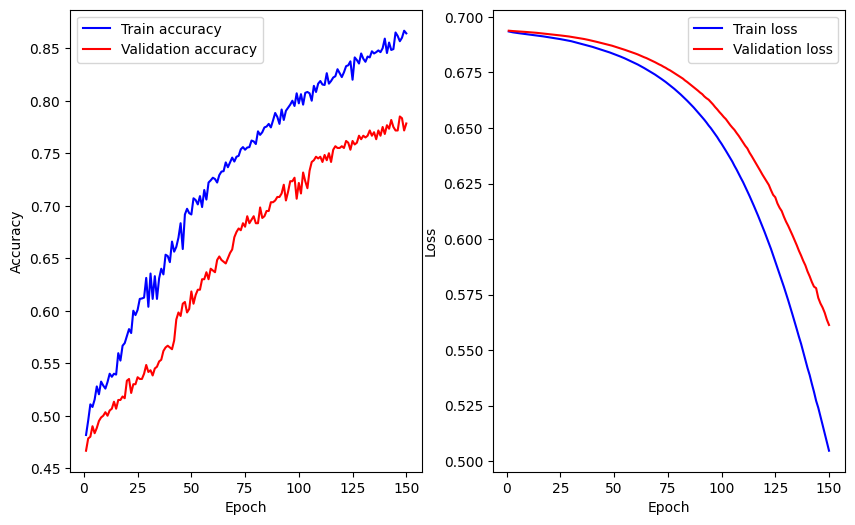

In [43]:
plot_nn_history(hist_9)

This model starts overfitting around epoch 25 (train accuracy ~= 60%, validation accuracy ~= 54%)

## Best model

Before starting with all the above neural network architectures and hyperparameters, we found a baseline accuracy of around 83% using default Logistic Regression model. Although relatively good, we expected to go much higher with our sequential network models.

Unfortunately, none of our trained models achieved a satisfactory performance with this dataset. So our **Baseline Logistic Regression** model proved to be the best model. However, it's going to need careful tuning to be really useful for normal sentiment analysis.

# Insights and key findings

# Next steps

# Acknowledgements